In [1]:
# Install Dependencies
# 1. Uninstall the incompatible "nightly" versions first
!pip uninstall -y torch torchvision torchaudio flash-attn

# 2. Install Stable PyTorch (2.5.1) compatible with CUDA 12.4
print("Installing Stable PyTorch 2.5.1...")
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124

# 3. Install other dependencies
!pip install -q --timeout=1000 accelerate bitsandbytes seaborn safetensors scikit-learn matplotlib transformers

# 4. Install Pre-built Flash Attention
print("Installing Flash Attention Wheel...")
!pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.0.post2/flash_attn-2.7.0.post2+cu124torch2.5cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Installing Stable PyTorch 2.5.1...
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 142.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.9 MB/s eta 0:00:00
     ━━━━━━━━━

In [2]:
# Install Flash Attention for Python 3.12 + CUDA 12.4 + PyTorch 2.5
# Install build dependencies first
!pip install packaging ninja

# Set MAX_JOBS to use all A100 CPU cores
import os
os.environ["MAX_JOBS"] = "8"

# Compile from source
!pip install flash-attn --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 120.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=255984554 sha256=51f6422861ed951b968428adc9fa7406027f73f2145be5e163810df6f459abea
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


In [21]:
#Import Libraries and Mount Google Drive
import os
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import (
    ViTForImageClassification,
    BitsAndBytesConfig
)
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device set to: cuda
GPU: NVIDIA A100-SXM4-40GB
CUDA Version: 12.4


In [22]:
#Define Paths and Verify Model/Dataset Locations

# Define paths pointing to Google Drive
PATHS = {
    "dataset_root": "/content/drive/MyDrive/Models/flower_data/dataset",
    "quant_4bit_dir": "/content/drive/MyDrive/Models/quant_4bit",
}

# Verify the paths exist
print("Verifying folder structure:")
for key, path in PATHS.items():
    if os.path.exists(path):
        print(f"✓ {key}: {path} - EXISTS")
    else:
        print(f"✗ {key}: {path} - NOT FOUND")
        print(f"  Please ensure the folder exists in your Google Drive")

# Check test directory specifically
test_dir = os.path.join(PATHS["dataset_root"], "test")
if os.path.exists(test_dir):
    print(f"\n✓ Test directory found: {test_dir}")
    # Count test images
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"  Found {len(test_images)} test images")
else:
    print(f"\n✗ Test directory not found: {test_dir}")

Verifying folder structure:
✓ dataset_root: /content/drive/MyDrive/Models/flower_data/dataset - EXISTS
✓ quant_4bit_dir: /content/drive/MyDrive/Models/quant_4bit - EXISTS

✓ Test directory found: /content/drive/MyDrive/Models/flower_data/dataset/test
  Found 819 test images


In [29]:
#Load 4-bit Quantized Model with FlashAttention-2
def load_quantized_model_with_flash_attn(model_dir, num_labels=102):
    """
    Load 4-bit quantized model with FlashAttention-2
    """
    print(f"Loading 4-bit model with FlashAttention-2 from {model_dir}...")

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )

    # Load model with FlashAttention-2
    model = ViTForImageClassification.from_pretrained(
        model_dir,
        quantization_config=bnb_config,
        attn_implementation="flash_attention_2",  # Enable FlashAttention-2
        device_map="auto",
        torch_dtype=torch.float16,
        num_labels=num_labels
    )

    model.eval()  # Set to evaluation mode
    print("Model loaded successfully!")

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

# Load the model
NUM_CLASSES = 102  # Flower dataset has 102 classes
model = load_quantized_model_with_flash_attn(PATHS["quant_4bit_dir"], NUM_CLASSES)

# Verify FlashAttention is being used
print("\nModel ready for inference with FlashAttention-2!")


Loading 4-bit model with FlashAttention-2 from /content/drive/MyDrive/Models/quant_4bit...


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Model loaded successfully!
Total parameters: 152,411,238
Trainable parameters: 1,195,110

Model ready for inference with FlashAttention-2!


In [30]:
#Prepare Test Dataset

def get_test_dataloader(root_dir, batch_size=32):
    """
    Create DataLoader for test dataset
    """
    test_dir = os.path.join(root_dir, 'test')

    # Standard ViT preprocessing (same as training/validation)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Check if test directory has ImageFolder structure (class subfolders)
    # or flat structure (all images in one folder)
    if os.path.isdir(test_dir):
        subdirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
        if subdirs and subdirs[0].isdigit():
            # ImageFolder structure (class subfolders)
            dataset = datasets.ImageFolder(test_dir, transform=transform)
            print(f"✓ Loaded test dataset with ImageFolder structure")
            print(f"  Number of classes: {len(dataset.classes)}")
            print(f"  Number of images: {len(dataset)}")
        else:
            # Flat structure - create custom dataset
            from torch.utils.data import Dataset

            class FlatImageFolder(Dataset):
                """Dataset for images stored directly in a folder (not in class subfolders)"""
                def __init__(self, root_dir, transform=None):
                    self.root_dir = root_dir
                    self.transform = transform
                    # Get all image files
                    self.image_files = [f for f in os.listdir(root_dir)
                                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
                    self.image_files.sort()

                def __len__(self):
                    return len(self.image_files)

                def __getitem__(self, idx):
                    img_path = os.path.join(self.root_dir, self.image_files[idx])
                    image = Image.open(img_path).convert('RGB')

                    if self.transform:
                        image = self.transform(image)

                    # Return dummy label since test set doesn't need labels
                    return image, 0

            dataset = FlatImageFolder(test_dir, transform=transform)
            print(f"✓ Loaded test dataset with flat structure")
            print(f"  Number of images: {len(dataset)}")
    else:
        raise FileNotFoundError(f"Test directory not found: {test_dir}")

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return loader, dataset

# Create test dataloader
test_loader, test_dataset = get_test_dataloader(PATHS["dataset_root"], batch_size=32)
print(f"\nTest DataLoader ready with batch size: {test_loader.batch_size}")


✓ Loaded test dataset with flat structure
  Number of images: 819

Test DataLoader ready with batch size: 32


In [31]:
def run_inference(model, dataloader, device):
    """
    Run inference on test dataset and collect predictions
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    inference_times = []

    print("Running inference on test dataset...")
    print(f"Total batches: {len(dataloader)}")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move images to device and convert to float16 for quantized model
            images = images.to(device, non_blocking=True).to(torch.float16)
            labels = labels.to(device, non_blocking=True)

            # Time inference
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start_time = time.time()

            # Forward pass
            outputs = model(images)
            logits = outputs.logits

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            inference_time = (time.time() - start_time) * 1000  # Convert to ms
            inference_times.append(inference_time / images.size(0))  # Per image

            # Get predictions
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(dataloader)} batches")

    # Calculate statistics
    avg_inference_time = np.mean(inference_times)
    throughput = 1000 / avg_inference_time  # images per second

    print(f"\nInference complete!")
    print(f"Average inference time per image: {avg_inference_time:.2f} ms")
    print(f"Throughput: {throughput:.2f} images/second")

    return all_predictions, all_labels, all_probs, avg_inference_time, throughput

# Run inference
predictions, labels, probabilities, avg_time, throughput = run_inference(model, test_loader, device)

Running inference on test dataset...
Total batches: 26
Processed 10/26 batches
Processed 20/26 batches

Inference complete!
Average inference time per image: 2.23 ms
Throughput: 449.11 images/second


In [35]:
import json

cat_to_name_path = os.path.join(PATHS["dataset_root"], "..", "cat_to_name.json")
if not os.path.exists(cat_to_name_path):
    # Try alternative path
    cat_to_name_path = os.path.join(PATHS["dataset_root"], "cat_to_name.json")

if os.path.exists(cat_to_name_path):
    with open(cat_to_name_path, 'r') as f:
        cat_to_name = json.load(f)
    # Convert string keys to integers for proper mapping
    class_names_dict = {int(k): v for k, v in cat_to_name.items()}
    print(f"Loaded class names from: {cat_to_name_path}")
    print(f"   Total classes: {len(class_names_dict)}")
else:
    print(f"cat_to_name.json not found at {cat_to_name_path}")
    print("   Using class indices instead of names")
    class_names_dict = {}

# Helper function to get class name
def get_class_name(class_idx):
    """Get class name from index, fallback to index if not found"""
    if class_idx in class_names_dict:
        return class_names_dict[class_idx]
    return f"Class {class_idx}"

# ImageFolder datasets have 'samples' attribute with (path, label) tuples
# FlatImageFolder returns dummy labels (all 0s), so we check if dataset is ImageFolder
has_real_labels = (
    hasattr(test_dataset, 'samples') and
    hasattr(test_dataset, 'classes') and
    len(set(labels)) > 1 and
    not all(l == 0 for l in labels)  # FlatImageFolder returns all 0s
)

if has_real_labels:
    # Calculate accuracy metrics
    accuracy = accuracy_score(labels, predictions)

    print(f"\n{'='*60}")
    print(f"TEST SET RESULTS")
    print(f"{'='*60}")
    print(f"Total test images: {len(predictions)}")
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")
    print(f"\nAverage inference time: {avg_time:.2f} ms/image")
    print(f"Throughput: {throughput:.2f} images/second")

    # Top-5 accuracy
    top5_correct = 0
    for i, label in enumerate(labels):
        top5_preds = np.argsort(probabilities[i])[-5:][::-1]
        if label in top5_preds:
            top5_correct += 1
    top5_accuracy = top5_correct / len(labels)
    print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")

    # Show sample predictions with class names
    print(f"\n{'='*60}")
    print("Sample Predictions (with class names):")
    print(f"{'='*60}")
    num_samples = min(10, len(predictions))
    for i in range(num_samples):
        pred_class = predictions[i]
        true_class = labels[i]
        confidence = probabilities[i][pred_class] * 100
        correct = "✓" if pred_class == true_class else "✗"

        pred_name = get_class_name(pred_class)
        true_name = get_class_name(true_class)

        print(f"Image {i+1}: Predicted: {pred_name} (Class {pred_class}, {confidence:.1f}%) | "
              f"True: {true_name} (Class {true_class}) {correct}")

    # Classification report with class names
    print(f"\n{'='*60}")
    print("Classification Report (Top 10 Classes):")
    print(f"{'='*60}")

    # Get unique classes in the test set
    unique_classes = sorted(set(labels))
    top_classes = unique_classes[:10]  # Show top 10 classes

    # Create target names for classification report
    target_names = [get_class_name(c) for c in top_classes]

    # Filter predictions and labels to only include top classes for report
    mask = np.isin(labels, top_classes)
    filtered_labels = np.array(labels)[mask]
    filtered_preds = np.array(predictions)[mask]

    if len(filtered_labels) > 0:
        print(classification_report(
            filtered_labels,
            filtered_preds,
            target_names=target_names,
            zero_division=0,
            labels=top_classes
        ))
        print(f"(Showing first 10 classes, total: {len(unique_classes)} classes in test set)")
    else:
        print("No samples found in top 10 classes for classification report")

    # Overall classification report (all classes)
    print(f"\n{'='*60}")
    print("Overall Classification Report (All Classes):")
    print(f"{'='*60}")
    print(classification_report(labels, predictions, zero_division=0))

else:
    print(f"\n{'='*60}")
    print(f"INFERENCE COMPLETE")
    print(f"{'='*60}")
    print(f"Total images processed: {len(predictions)}")
    print(f"Average inference time: {avg_time:.2f} ms/image")
    print(f"Throughput: {throughput:.2f} images/second")

    # Show sample predictions
    if class_names_dict:
        print(f"\n{'='*60}")
        print("Sample Predictions (with class names):")
        print(f"{'='*60}")
        num_samples = min(10, len(predictions))
        for i in range(num_samples):
            pred_class = predictions[i]
            confidence = probabilities[i][pred_class] * 100
            pred_name = get_class_name(pred_class)

            # Get top-3 predictions
            top3_indices = np.argsort(probabilities[i])[-3:][::-1]
            top3_names = [get_class_name(c) for c in top3_indices]
            top3_probs = [probabilities[i][c] * 100 for c in top3_indices]

            print(f"Image {i+1}: {pred_name} (Class {pred_class}, {confidence:.1f}%)")
            print(f"           Top-3: {', '.join([f'{n} ({p:.1f}%)' for n, p in zip(top3_names, top3_probs)])}")


Loaded class names from: /content/drive/MyDrive/Models/flower_data/dataset/../cat_to_name.json
   Total classes: 102

INFERENCE COMPLETE
Total images processed: 819
Average inference time: 2.23 ms/image
Throughput: 449.11 images/second

Sample Predictions (with class names):
Image 1: passion flower (Class 77, 10.1%)
           Top-3: passion flower (10.1%), globe thistle (3.0%), pink primrose (2.5%)
Image 2: passion flower (Class 77, 39.8%)
           Top-3: passion flower (39.8%), camellia (2.4%), tiger lily (2.1%)
Image 3: passion flower (Class 77, 42.9%)
           Top-3: passion flower (42.9%), tiger lily (2.2%), anthurium (1.7%)
Image 4: passion flower (Class 77, 24.4%)
           Top-3: passion flower (24.4%), pink primrose (4.1%), globe thistle (2.1%)
Image 5: passion flower (Class 77, 32.8%)
           Top-3: passion flower (32.8%), pink primrose (2.0%), barbeton daisy (2.0%)
Image 6: passion flower (Class 77, 22.2%)
           Top-3: passion flower (22.2%), camellia (4.1%), pi

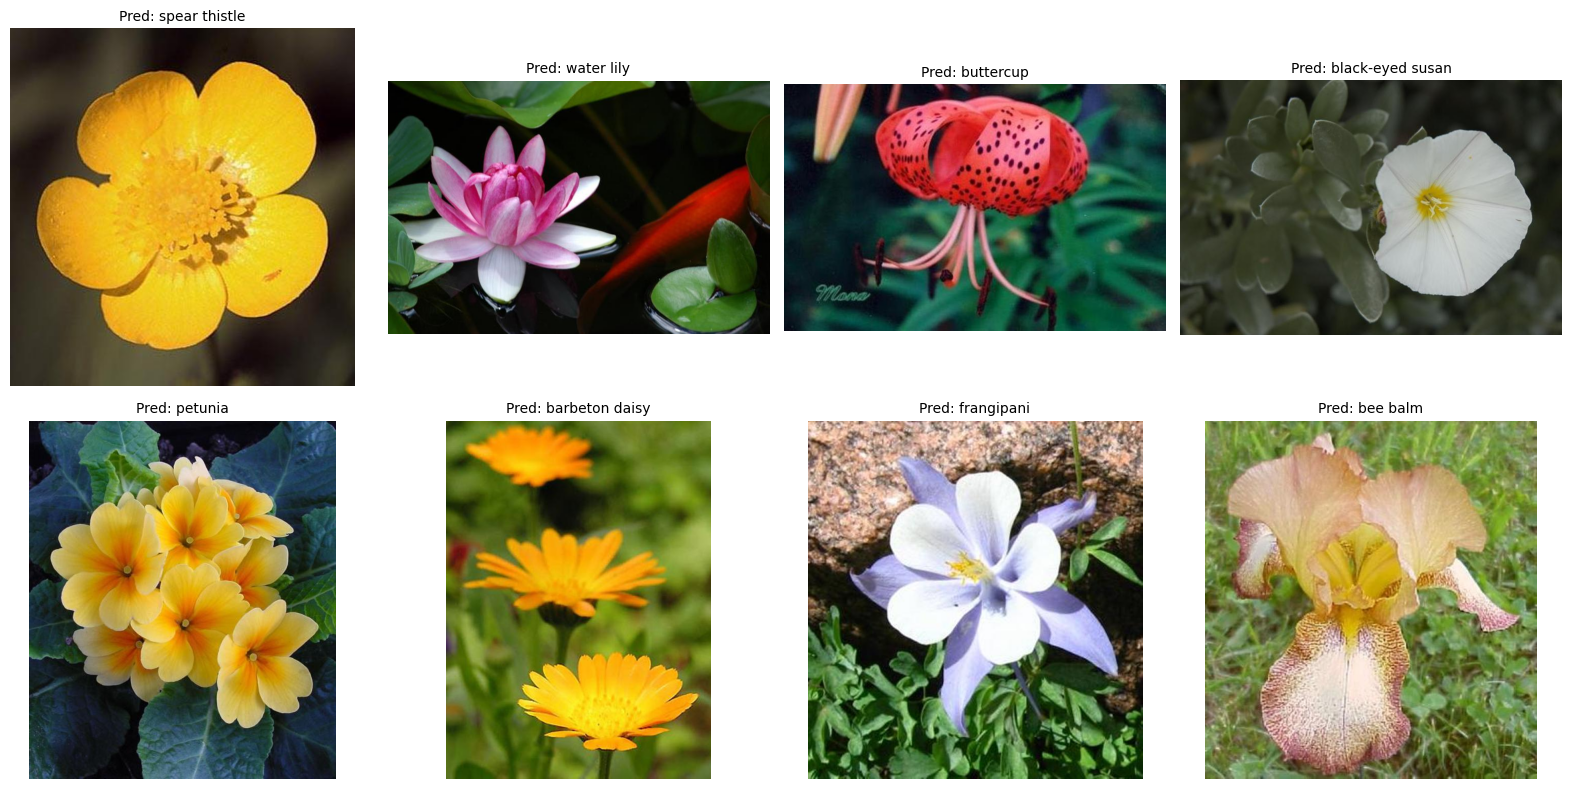


Sample 485 - Top 3 Predictions:
  1. spear thistle (Class 14)
  2. silverbush (Class 64)
  3. bolero deep blue (Class 45)


In [36]:
def visualize_predictions(dataset, predictions, probabilities, num_samples=8, class_names_dict=None):
    """
    Visualize sample predictions from test set
    Uses class_names_dict from cat_to_name.json if available
    """
    # Get random samples
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for idx, ax in zip(indices, axes):
        # Get image (need to load original, not transformed)
        if hasattr(dataset, 'samples'):
            # ImageFolder structure
            img_path, _ = dataset.samples[idx]
        elif hasattr(dataset, 'image_files'):
            # Flat structure
            img_path = os.path.join(dataset.root_dir, dataset.image_files[idx])
        else:
            continue

        img = Image.open(img_path).convert('RGB')

        # Get prediction
        pred_class = predictions[idx]

        # Display image
        ax.imshow(img)
        ax.axis('off')

        # Create label text using class names from cat_to_name.json
        if class_names_dict and pred_class in class_names_dict:
            pred_label = class_names_dict[pred_class]
        else:
            pred_label = f"Class {pred_class}"

        title = f"Pred: {pred_label}"
        ax.set_title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print top-3 predictions for first sample with class names
    if len(indices) > 0:
        first_idx = indices[0]
        print(f"\nSample {first_idx} - Top 3 Predictions:")
        top3_indices = np.argsort(probabilities[first_idx])[-3:][::-1]
        for rank, class_idx in enumerate(top3_indices, 1):
            if class_names_dict and class_idx in class_names_dict:
                class_name = class_names_dict[class_idx]
                print(f"  {rank}. {class_name} (Class {class_idx})")
            else:
                print(f"  {rank}. Class {class_idx}")

# Visualize predictions
try:
    # class_names_dict should be available from Cell 8
    if 'class_names_dict' in globals():
        visualize_predictions(test_dataset, predictions, probabilities, num_samples=8, class_names_dict=class_names_dict)
    else:
        # Fallback: try to load it again
        cat_to_name_path = os.path.join(PATHS["dataset_root"], "..", "cat_to_name.json")
        if not os.path.exists(cat_to_name_path):
            cat_to_name_path = os.path.join(PATHS["dataset_root"], "cat_to_name.json")

        if os.path.exists(cat_to_name_path):
            with open(cat_to_name_path, 'r') as f:
                cat_to_name = json.load(f)
            class_names_dict = {int(k): v for k, v in cat_to_name.items()}
            visualize_predictions(test_dataset, predictions, probabilities, num_samples=8, class_names_dict=class_names_dict)
        else:
            visualize_predictions(test_dataset, predictions, probabilities, num_samples=8, class_names_dict=None)
except Exception as e:
    print(f"Could not visualize predictions: {e}")
    print("This is normal if the dataset structure doesn't support visualization")

In [38]:
import pandas as pd

if 'class_names_dict' not in globals():
    # Try to load it again
    cat_to_name_path = os.path.join(PATHS["dataset_root"], "..", "cat_to_name.json")
    if not os.path.exists(cat_to_name_path):
        cat_to_name_path = os.path.join(PATHS["dataset_root"], "cat_to_name.json")

    if os.path.exists(cat_to_name_path):
        with open(cat_to_name_path, 'r') as f:
            cat_to_name = json.load(f)
        class_names_dict = {int(k): v for k, v in cat_to_name.items()}
    else:
        class_names_dict = {}

# Create results DataFrame
results_data = []

for i, pred in enumerate(predictions):
    # Get top-5 predictions
    top5_indices = np.argsort(probabilities[i])[-5:][::-1]
    top5_probs = probabilities[i][top5_indices]

    # Get class names
    pred_class_name = class_names_dict.get(int(pred), f"Class {pred}")
    top5_class_names = [class_names_dict.get(int(c), f"Class {c}") for c in top5_indices]

    result = {
        'image_index': i,
        'predicted_class': int(pred),
        'predicted_class_name': pred_class_name,
        'top5_classes': ','.join(map(str, top5_indices)),
        'top5_class_names': ','.join(top5_class_names),
        'top5_confidences': ','.join([f"{p*100:.2f}" for p in top5_probs])
    }

    if hasattr(test_dataset, 'samples'):
        result['image_path'] = test_dataset.samples[i][0]
    elif hasattr(test_dataset, 'image_files'):
        result['image_path'] = os.path.join(test_dataset.root_dir, test_dataset.image_files[i])

    results_data.append(result)

df_results = pd.DataFrame(results_data)

# Save to CSV
output_path = '/content/drive/MyDrive/Models/inference_results_4bit_fa2.csv'
df_results.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")
print(f"\nFirst 5 predictions (with class names):")
print(df_results[['image_index', 'predicted_class', 'predicted_class_name']].head())

# Summary statistics
print(f"\n{'='*60}")
print("INFERENCE SUMMARY")
print(f"{'='*60}")
print(f"Total images: {len(df_results)}")
print(f"Average inference time: {avg_time:.2f} ms/image")
print(f"Throughput: {throughput:.2f} images/second")

# Show most common predictions
if 'predicted_class_name' in df_results.columns:
    print(f"\n{'='*60}")
    print("Most Common Predictions:")
    print(f"{'='*60}")
    top_predictions = df_results['predicted_class_name'].value_counts().head(10)
    for class_name, count in top_predictions.items():
        print(f"  {class_name}: {count} images ({count/len(df_results)*100:.1f}%)")


Predictions saved to: /content/drive/MyDrive/Models/inference_results_4bit_fa2.csv

First 5 predictions (with class names):
   image_index  predicted_class predicted_class_name
0            0               77       passion flower
1            1               77       passion flower
2            2               77       passion flower
3            3               77       passion flower
4            4               77       passion flower

INFERENCE SUMMARY
Total images: 819
Average inference time: 2.23 ms/image
Throughput: 449.11 images/second

Most Common Predictions:
  barbeton daisy: 72 images (8.8%)
  passion flower: 51 images (6.2%)
  camellia: 47 images (5.7%)
  gazania: 39 images (4.8%)
  water lily: 32 images (3.9%)
  lenten rose: 28 images (3.4%)
  canna lily: 27 images (3.3%)
  buttercup: 24 images (2.9%)
  sword lily: 23 images (2.8%)
  oxeye daisy: 23 images (2.8%)
